In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 分类树预测泰坦尼克生存
以经典的 titanic 数据集为例，它记录了泰坦尼克号上乘客的信息，包括性别、年龄、船舱等级、票价等，目标是预测乘客是否在泰坦尼克号沉没事件
中生存下来（1 表示生存，0 表示死亡）。

同时，借助管道技术，展示数据预处理、缺失值插补、特征工程、图学习器调参的流程化操作。

(1) 准备数据

In [1]:

library(tidyverse)
library(mlr3verse)
titanic = read_csv("/kaggle/input/titanic/titanic.csv")
glimpse(titanic)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: mlr3

Rows: 1309 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): survived, name, sex, ticket, cabin, embarked
dbl (5): pclass, age, sib_sp, parch, fare

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,309
Columns: 11
$ survived <chr> "no", "yes", "yes", "yes", "no", "no", "no", "no", "yes", "ye…
$ pclass   <dbl> 3, 1, 3, 1, 3, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3, 2…
$ name     <chr> "Braund, Mr. Owen Harris", "Cumings, Mrs. John Bradley (Flore…
$ sex      <chr> "male", "female", "female", "female", "male", "male", "male",…
$ age      <dbl> 22, 38, 26, 35, 35, NA, 54, 2, 27, 14, 4, 58, 20, 39, 14, 55,…
$ sib_sp   <dbl> 1, 1, 0, 1, 0, 0, 0, 3, 0, 1, 1, 0, 0, 1, 0, 0, 4, 0, 1, 0, 0…
$ parch    <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 5, 0, 0, 1, 0, 0, 0, 0…
$ ticket   <chr> "A/5 21171", "PC 17599", "STON/O2. 3101282", "113803", "37345…
$ fare     <dbl> 7.2500, 71.2833, 7.9250, 53.1000, 8.0500, 8.4583, 51.8625, 21…
$ cabin    <chr> NA, "C85", NA, "C123", NA, NA, "E46", NA, NA, NA, "G6", "C103…
$ embarked <chr> "S", "C", "S", "S", "S", "Q", "S", "S", "S", "C", "S", "S", "…


(2) 数据预处理

以下是在机器学习流程之外，先对数据做了预处理，同样的预处理也可以作为特征工程，在图学习器管道步中来做。

• 类型转化：有些字符型特征，转化为（有序）因子型

In [2]:

titanic = titanic %>%
mutate(survived = factor(survived, c("yes","no")),
sex = factor(sex, c("female","male")),
embarked = factor(embarked, c("C","Q","S")),
pclass = factor(pclass, c("1","2","3"),
ordered = TRUE),
across(c(parch,sib_sp), as.integer))

• 构建新特征：在原特征基础上，从背景知识出发构建对预测更有帮助的若干新特征：人均票价、座舱等级、头衔、姓氏、船票前缀。这里主要用到基于正则表达式的字符串提取技术。

In [3]:

titanic = titanic %>%
mutate(fare_per_person = fare / (parch + sib_sp + 1),
       deck = factor(str_sub(cabin, 1, 1)),
       title = factor(str_extract(name, "(?<=, ).*(?=\\.)")),
       surname = factor(str_extract(name, "^.*(?=,)")),
       ticket_prefix = factor(
         str_extract(ticket, "^.*(?= )"))) %>%
select(!where(is.character))


(3) 创建任务

用 as_task_classif() 函数创建分类任务：

`task = as_task_classif(titanic, target = "survived")`

titanic 数据的目标列 survived，前 891 行不缺失，892:1309 行缺失，设置行角色从”use” 移除，即不用于训练和测试：

In [4]:
task = as_task_classif(titanic, target = "survived")

In [5]:

task$set_row_roles(892:1309, remove_from = "use")
task
 

<TaskClassif:titanic> (891 x 13)
* Target: survived
* Properties: twoclass
* Features (12):
  - fct (6): deck, embarked, sex, surname, ticket_prefix, title
  - dbl (3): age, fare, fare_per_person
  - int (2): parch, sib_sp
  - ord (1): pclass

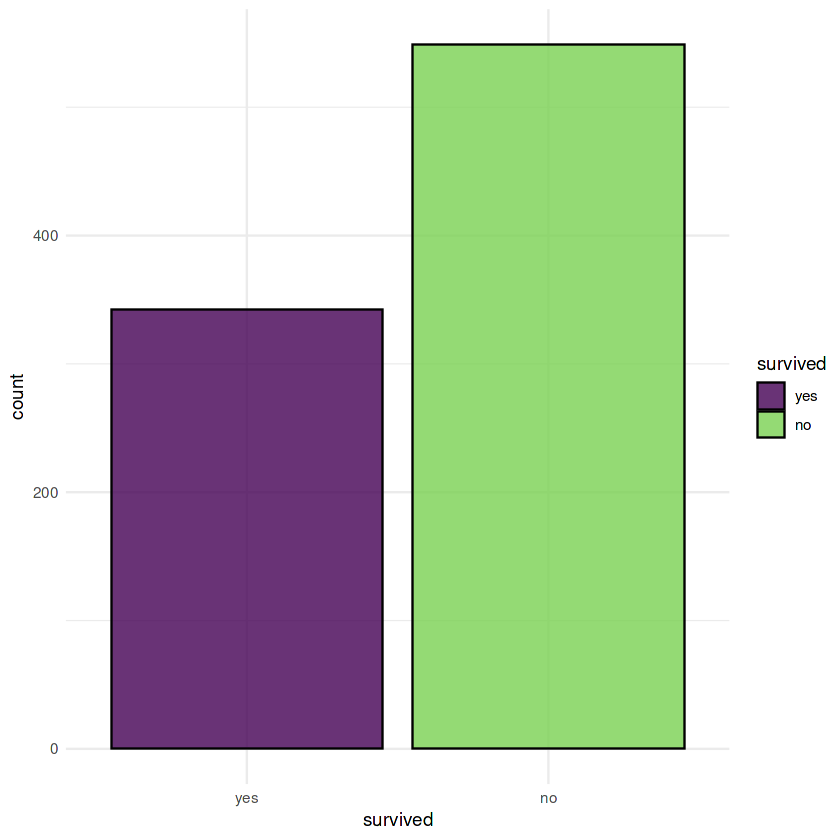

In [6]:
# 简单可视化探索
autoplot(task)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message:
“Removed 177 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 177 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 177 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 177 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 177 rows containing non-finite outside the scale range (`stat_bin()`).”


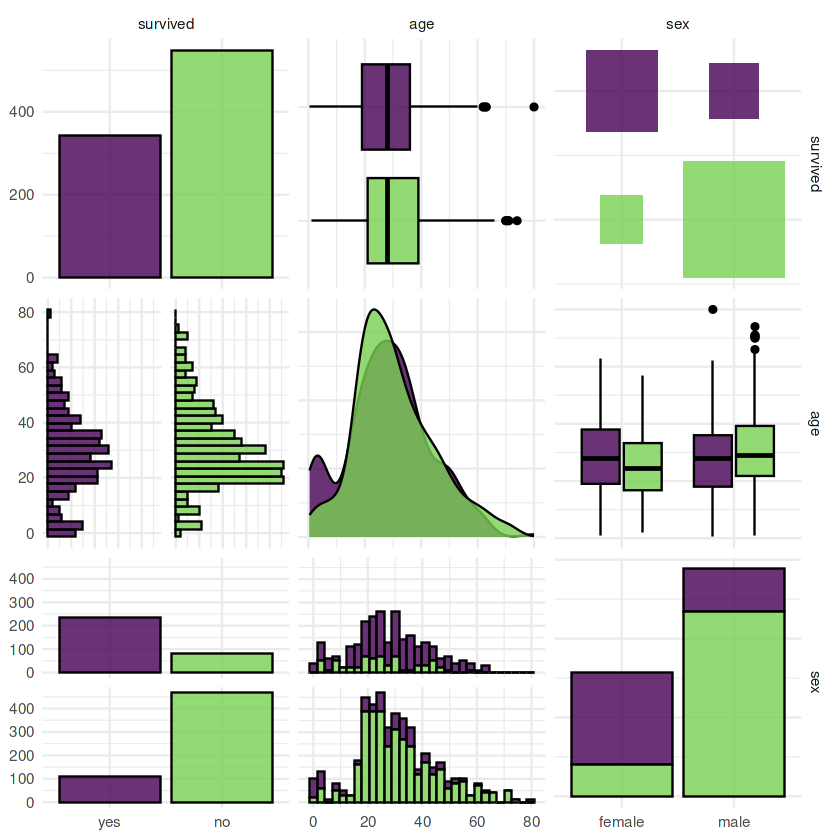

In [7]:
autoplot(task$clone()$select(
c("sex", "age")), type = "pairs")

(4) 划分训练集和测试集

做留出重抽样，80% 作为训练集，其余 20% 作为测试集。为了保持训练集、测试集的因变量数据具有相似的分布，采用分层抽样方法：

• 用 partition() 函数对任务做划分，默认按因变量分层，返回列表包含训练集索引和测试集索引。



In [8]:
set.seed(123)
split = partition(task, ratio = 0.8)
# 默认 stratify = TRUE

(5) 特征工程

(i) 处理缺失值

查看缺失情况：


In [9]:
task$missings()

survived             age            deck        embarked            fare 
              0             177             687               2               0 
fare_per_person           parch          pclass             sex          sib_sp 
              0               0               0               0               0 
        surname   ticket_prefix           title 
              0             665               0

按想做的插补流程搭建管道图：

• 对数值特征：增加一列是否缺失的标记列，同时用直方图法插补，需要接特征并

• 对因子特征：超出范围插补，特别适合基于树的模型

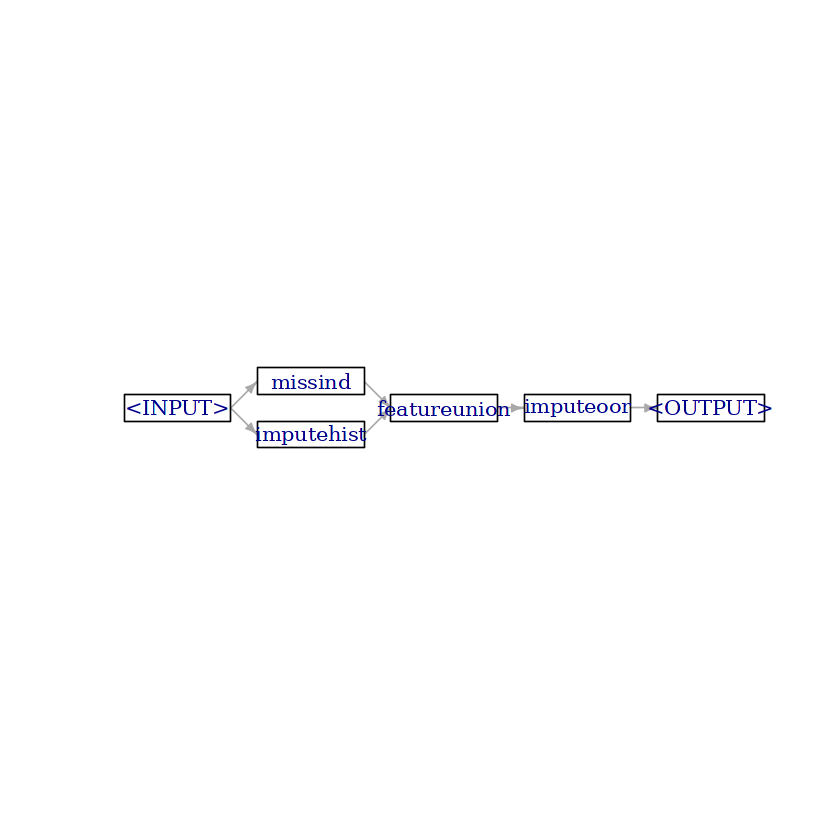

In [10]:
po_indicator = po("missind",
                  affect_columns = selector_type(c("numeric", "integer")),
                  type = "numeric")
impute_step = gunion(
  list(po_indicator, po("imputehist"))) %>>%
po("featureunion") %>>%
po("imputeoor")
impute_step$plot(horizontal = TRUE)

(ii) 处理分类特征

• 折叠占数据 3% 以下的因子水平

• 移除空的、训练期间不存在的因子水平

• 若某些因子水平在训练时未出现，而只是在预测时出现，则取一个随机水平值

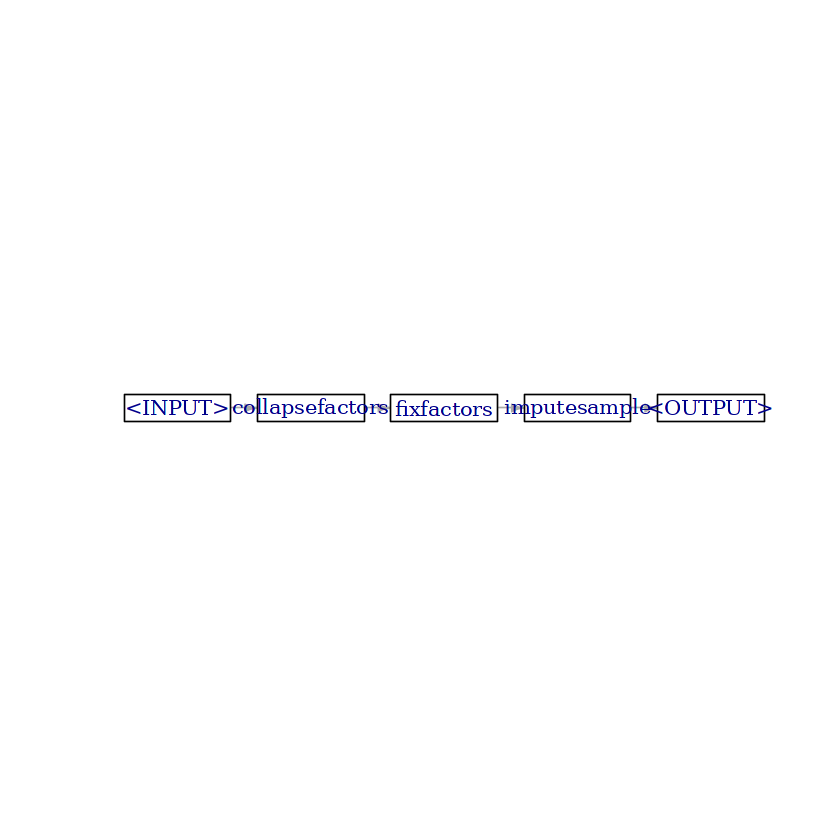

In [11]:
cat_step = po("collapsefactors",
param_vals = list(
no_collapse_above_prevalence = 0.03)) %>>%
po("fixfactors") %>>%
po("imputesample")
cat_step$plot(horizontal = TRUE)

(6) 选择学习器

选择决策树分类学习器，封装自 rpart::rpart()，设置 keep_model= TRUE 以保存模型用于可视化等。

In [12]:

rpart = lrn("classif.rpart", predict_type = "prob",
keep_model = TRUE,
cp = to_tune(p_dbl(0, 0.1)),
minsplit = to_tune(p_int(10, 20)),
maxdepth = to_tune(p_int(2, 10)))
rpart
 

<LearnerClassifRpart:classif.rpart>: Classification Tree
* Model: -
* Parameters: cp=<ObjectTuneToken>, keep_model=TRUE,
  maxdepth=<ObjectTuneToken>, minsplit=<ObjectTuneToken>, xval=0
* Packages: mlr3, rpart
* Predict Types:  response, [prob]
* Feature Types: logical, integer, numeric, factor, ordered
* Properties: importance, missings, multiclass, selected_features,
  twoclass, weights

接入预处理部分，构建完整的图：



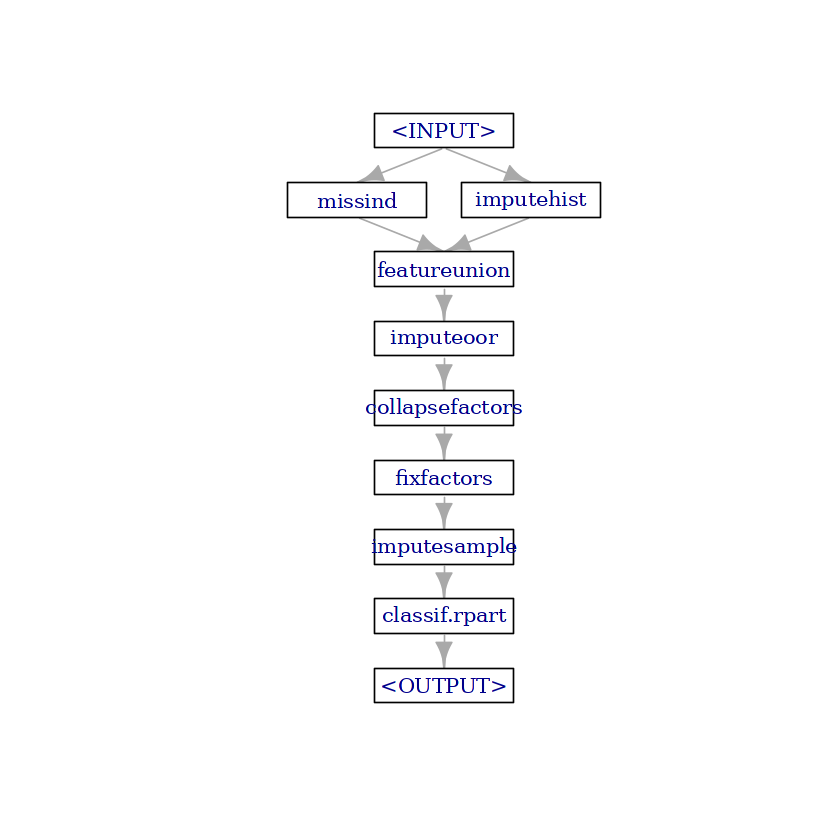

In [13]:
graph = impute_step %>>% cat_step %>>% rpart
graph$plot()

转化为图学习器：


In [14]:
glrn = as_learner(graph)

(8) 超参数调参

在选择学习器时，已经设置了对 cp, minsplit, maxdepth 做调参。

使用自动调参器，需要设置学习器、重抽样方法、模型评估指标、终止条件、搜索方法。



In [15]:
at = auto_tuner(
tuner = tnr("random_search"),
learner = glrn,
resampling = rsmp("cv", folds = 5),
measure = msr("classif.auc"),
term_evals = 10)

在训练集上启动自动调参过程：

In [17]:

set.seed(123)
at$train(task, row_ids = split$train)
#查看最优超参数：
at$tuning_result
 

INFO  [03:09:53.453] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerBatchRandomSearch>' and '<TerminatorEvals> [n_evals=10, k=0]'
INFO  [03:09:53.582] [bbotk] Evaluating 1 configuration(s)
INFO  [03:09:53.610] [mlr3] Running benchmark with 5 resampling iterations
INFO  [03:09:53.693] [mlr3] Applying learner 'missind.imputehist.featureunion.imputeoor.collapsefactors.fixfactors.imputesample.classif.rpart' on task 'titanic' (iter 1/5)
INFO  [03:09:55.160] [mlr3] Applying learner 'missind.imputehist.featureunion.imputeoor.collapsefactors.fixfactors.imputesample.classif.rpart' on task 'titanic' (iter 2/5)
INFO  [03:09:56.235] [mlr3] Applying learner 'missind.imputehist.featureunion.imputeoor.collapsefactors.fixfactors.imputesample.classif.rpart' on task 'titanic' (iter 3/5)
INFO  [03:09:57.294] [mlr3] Applying learner 'missind.imputehist.featureunion.imputeoor.collapsefactors.fixfactors.imputesample.classif.rpart' on task 'titanic' (iter 4/5)
INFO  [03:09:58.334] [mlr3] Applyin

classif.rpart.cp,classif.rpart.maxdepth,classif.rpart.minsplit,learner_param_vals,x_domain,classif.auc
<dbl>,<int>,<int>,<list>,<list>,<dbl>
0.01999118,9,18,"missing_train, numeric, structure(function (task) , {, task$feature_types[get(""type"") %in% types, get(""id"")], }, repr = ""selector_type(c(\""numeric\"", \""integer\""))"", class = c(""Selector"", , ""function"")), TRUE, 1, 1, 0.03, 2, TRUE, TRUE, 0, 0.01999118, 9, 18","0.01999118, 9.00000000, 18.00000000",0.8261525


可视化超参数 maxdepth 和 minsplit 的变化对模型性能的影响：

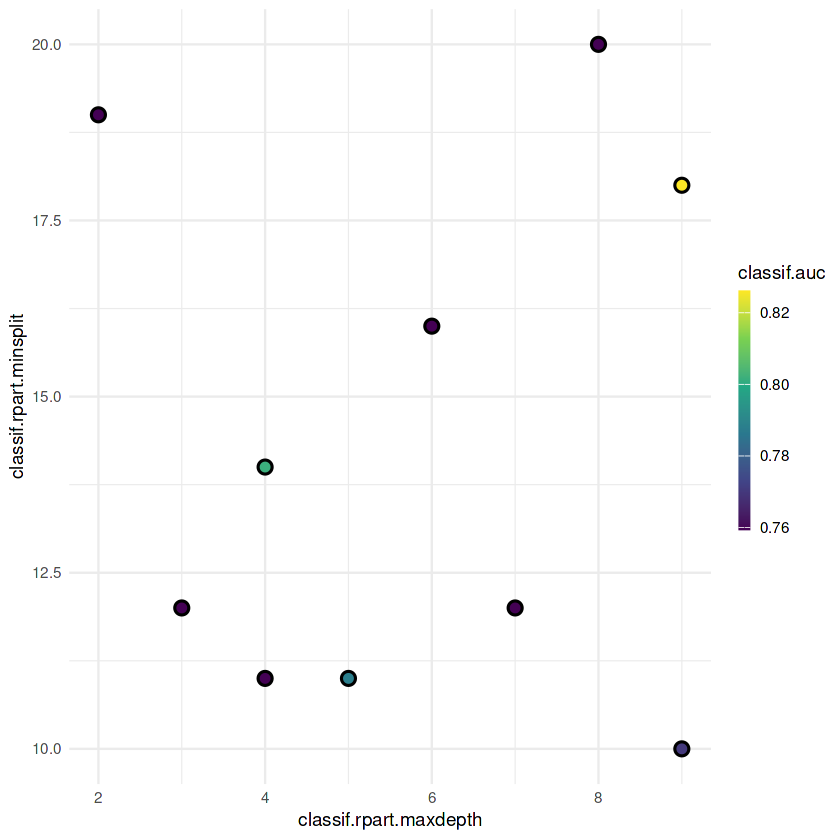

In [18]:

autoplot(at$tuning_instance, type = "points",
         cols_x = c("classif.rpart.maxdepth",
           "classif.rpart.minsplit"))

(9) 训练模型
自动调参器已经使用超参数调参得到最优超参数在整个训练集上重新训练，用

$base_learner() 方法可以取出图学习器的基学习器，这里是训练好的决策树学习器。

查看特征重要性：

In [19]:
learner = at$base_learner()

In [20]:
learner$importance()

title             sex            fare fare_per_person          pclass 
      97.293300       82.367141       54.562378       42.259494       35.789570 
          parch             age          sib_sp            deck     missing_age 
      33.204075       25.768221       24.355798       19.012229        4.312075 
        surname 
       1.541606

In [24]:
library(ggparty)
autoplot(learner, type = "ggparty")

ERROR: Error in library(ggparty): there is no package called ‘ggparty’


In [22]:
install.packages("ggparty")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“unable to access index for repository http://cran.rstudio.com/src/contrib:
  cannot open URL 'http://cran.rstudio.com/src/contrib/PACKAGES'”
Warning message:
“package ‘ggparty’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


(10) 模型预测及评估

在测试集上做预测：

In [23]:
pred = at$predict(task, row_ids = split$test)
pred

<PredictionClassif> for 178 observations:
    row_ids truth response   prob.yes   prob.no
          1    no       no 0.09792285 0.9020772
         17    no       no 0.09677419 0.9032258
         30    no       no 0.09792285 0.9020772
---                                            
        830   yes      yes 0.87974684 0.1202532
        859   yes      yes 0.59803922 0.4019608
        867   yes      yes 0.87974684 0.1202532

(11) 评估模型性能

In [25]:
pred$confusion # 混淆矩阵
#> truth
#> response yes no
#> yes 57 19
#> no 11 91
pred$score(msr("classif.acc")) # 准确率
#> classif.acc
#> 0.831
pred$score(msr("classif.recall")) # 召回率
#> classif.recall
#> 0.838
pred$score(msr("classif.auc")) # AUC

        truth
response yes no
     yes  57 19
     no   11 91

classif.acc 
  0.8314607

classif.recall 
     0.8382353

classif.auc 
  0.8633021

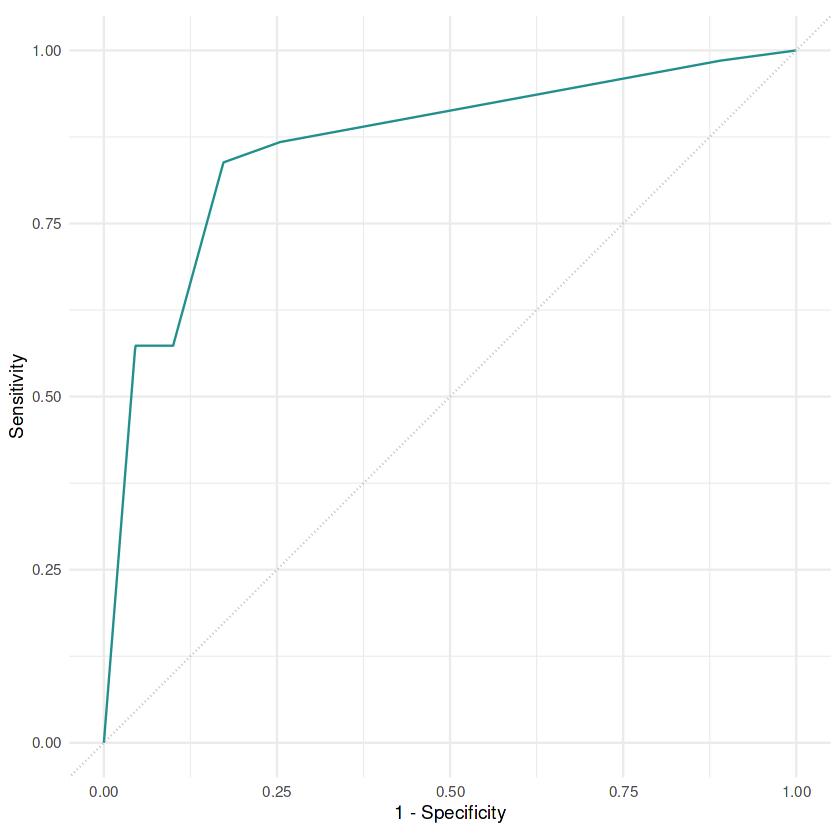

In [26]:
autoplot(pred, type = "roc") # ROC 曲线

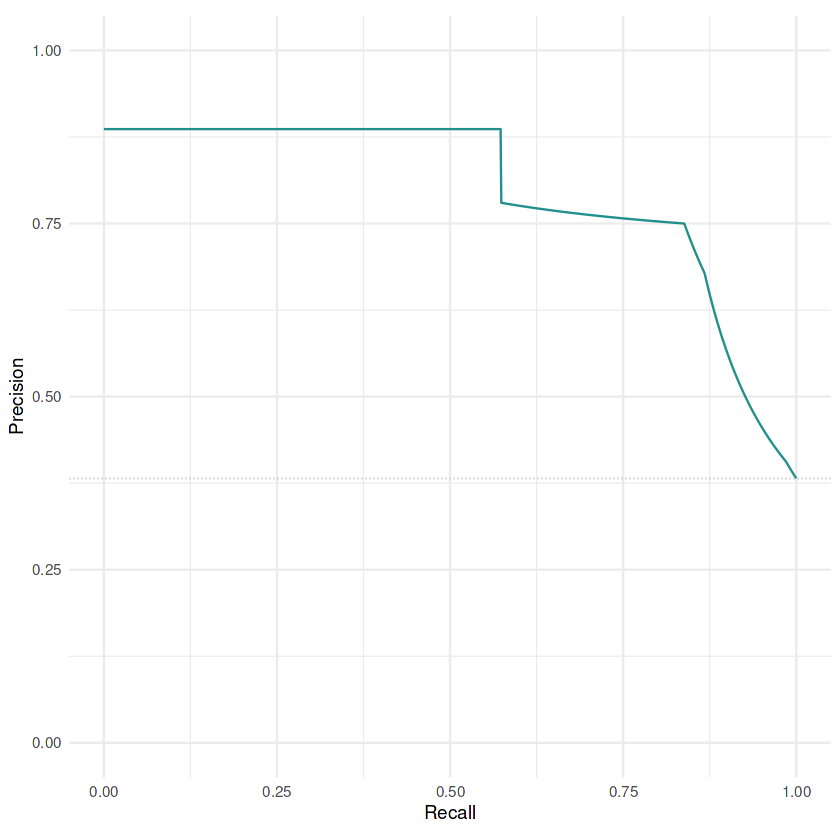

In [27]:
autoplot(pred, type = "prc") # PR 曲线

(12) 预测新数据
取出任务中的没有 use 数据作为预测的新数据：

In [28]:
newdata = task$data(rows = 892:1309)
at$predict_newdata(newdata)

<PredictionClassif> for 418 observations:
    row_ids truth response   prob.yes   prob.no
          1  <NA>       no 0.09792285 0.9020772
          2  <NA>      yes 0.59803922 0.4019608
          3  <NA>       no 0.09792285 0.9020772
---                                            
        416  <NA>       no 0.09792285 0.9020772
        417  <NA>       no 0.09792285 0.9020772
        418  <NA>      yes 0.59803922 0.4019608

## 回归树预测高炉发电量
联合循环发电厂数据集（CCPP）是来自 UCI 机器学习库的数据集，包含9568 个观测，4 个特征。这些特征主要涵盖了影响联合循环发电厂发电效率
的因素，包括环境温度（AT）、大气压力（AP）、相对湿度（RH）和排气压力（V）。目标变量是发电厂的净电力输出（PE），即发电厂在一个小时内的净发电量。

(1) 准备数据

通过百度网盘分享的文件：CCPP.xlsx

链接：https://pan.baidu.com/s/1n0m6hyJOPjvrKz8FYAwI9Q?pwd=6868 
 

In [29]:
dat = readxl::read_xlsx("/kaggle/input/ccppaa/CCPP.xlsx")
dat

AT,V,AP,RH,PE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14.96,41.76,1024.07,73.17,463.26
25.18,62.96,1020.04,59.08,444.37
5.11,39.40,1012.16,92.14,488.56
20.86,57.32,1010.24,76.64,446.48
10.82,37.50,1009.23,96.62,473.90
26.27,59.44,1012.23,58.77,443.67
15.89,43.96,1014.02,75.24,467.35
9.48,44.71,1019.12,66.43,478.42
14.64,45.00,1021.78,41.25,475.98


(2) 创建任务

用 as_task_regr() 函数创建回归任务：

In [30]:
task = as_task_regr(dat, target = "PE")
task

<TaskRegr:dat> (9568 x 5)
* Target: PE
* Properties: -
* Features (4):
  - dbl (4): AP, AT, RH, V

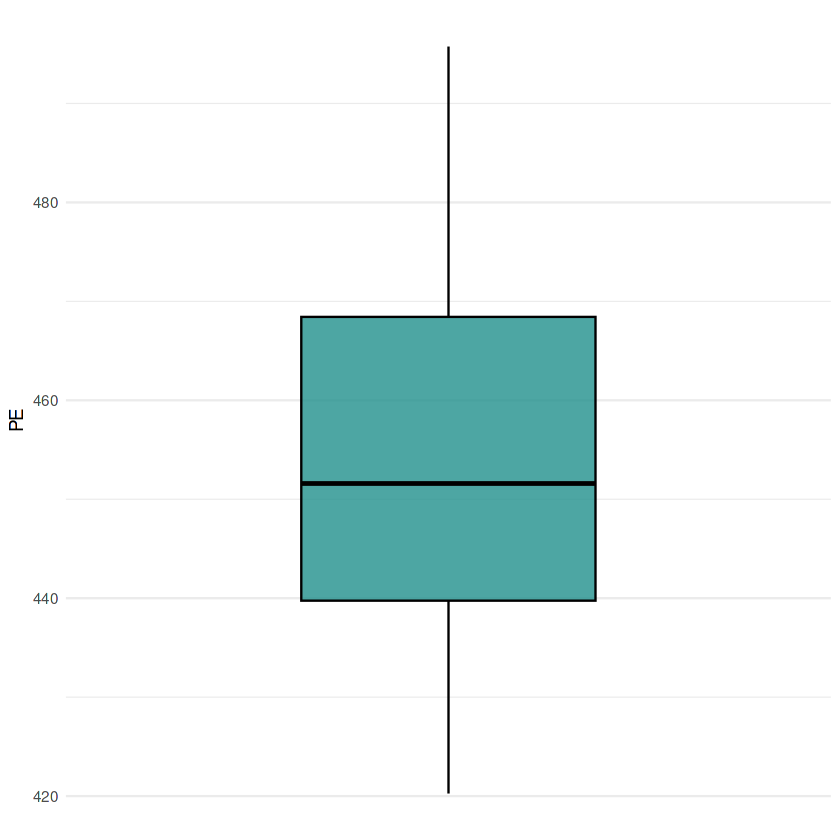

In [31]:
#可视化任务：
autoplot(task)

简单探索特征与目标之间的关系，只随机抽取部分行：

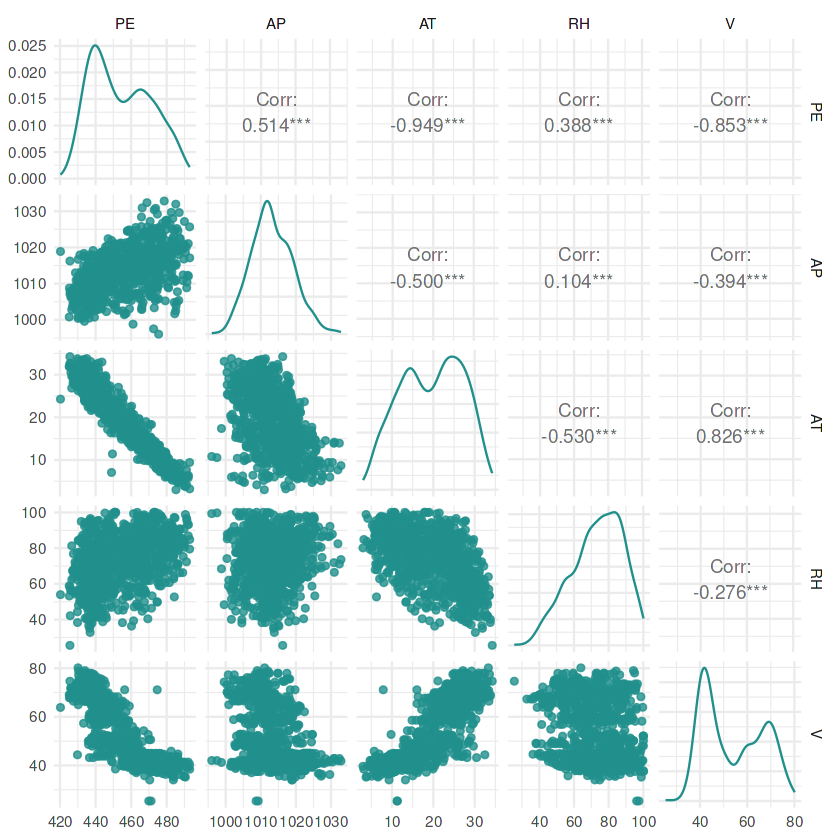

In [32]:

filtered = task$clone()$filter(
  sample(task$nrow, 1000))
autoplot(filtered, type = "pairs")


可见，4 个特征都与目标变量具有显著的线性相关性。

(3) 选择学习器

选择决策树回归学习器：

In [33]:

learner = lrn("regr.rpart", keep_model = TRUE)
# 需要 rpart 包
learner
#> <LearnerRegrRpart:regr.rpart>: Regression Tree
#> * Model: -
#> * Parameters: keep_model=TRUE, xval=0
#> * Packages: mlr3, rpart
#> * Predict Types: [response]
#> * Feature Types: logical, integer, numeric, factor, orde
#> * Properties: importance, missings, selected_features, w

<LearnerRegrRpart:regr.rpart>: Regression Tree
* Model: -
* Parameters: keep_model=TRUE, xval=0
* Packages: mlr3, rpart
* Predict Types:  [response]
* Feature Types: logical, integer, numeric, factor, ordered
* Properties: importance, missings, selected_features, weights

(4) 划分训练集和测试集

做留出重抽样，70% 作为训练集，其余 30% 作为测试集。为了保持训练集、测试集的因变量数据具有相似的分布，采用分层抽样方法：

• 用 partition() 函数对任务做划分，默认按因变量分层，返回列表包含训练集索引和测试集索引。

In [34]:
set.seed(123)
split = partition(task, ratio = 0.7)
# 默认 stratify = TRUE

(5) 超参数调参

对主要超参数 cp, minsplit, maxdepth 做调参。使用自动调参器，需要设置学习器、重抽样方法、模型评估指标、搜索空间、终止条件、搜索方法。

In [35]:
search_space = ps(
cp = p_dbl(0, 0.1),
minsplit = p_int(10, 50),
maxdepth = p_int(2, 8))

使用自动调参器，需要设置学习器、重抽样方法、模型评估指标、搜索空间、终止条件、搜索方法。

In [36]:

at = auto_tuner(
tuner = tnr("grid_search", resolution = 5),
learner = learner,
resampling = rsmp("cv", folds = 3),
measure = msr("regr.rmse"),
search_space = search_space)


In [37]:
# 在训练集上启动自动调参过程：
at$train(task, row_ids = split$train)

INFO  [03:29:07.988] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerBatchGridSearch>' and '<TerminatorNone>'
INFO  [03:29:08.049] [bbotk] Evaluating 1 configuration(s)
INFO  [03:29:08.064] [mlr3] Running benchmark with 3 resampling iterations
INFO  [03:29:08.076] [mlr3] Applying learner 'regr.rpart' on task 'dat' (iter 1/3)
INFO  [03:29:08.159] [mlr3] Applying learner 'regr.rpart' on task 'dat' (iter 2/3)
INFO  [03:29:08.255] [mlr3] Applying learner 'regr.rpart' on task 'dat' (iter 3/3)
INFO  [03:29:08.331] [mlr3] Finished benchmark
INFO  [03:29:08.429] [bbotk] Result of batch 1:
INFO  [03:29:08.434] [bbotk]     cp minsplit maxdepth regr.rmse warnings errors runtime_learners
INFO  [03:29:08.434] [bbotk]  0.075       50        5  8.565138        0      0            0.153
INFO  [03:29:08.434] [bbotk]                                 uhash
INFO  [03:29:08.434] [bbotk]  5f4dcc26-2070-45f0-8e31-f3adbb48d710
INFO  [03:29:08.440] [bbotk] Evaluating 1 configuration(s)
INFO  [03:29:

查看最优超参数：

In [38]:
at$tuning_result

cp,minsplit,maxdepth,learner_param_vals,x_domain,regr.rmse
<dbl>,<int>,<int>,<list>,<list>,<dbl>
0,10,8,"1, 0, 0, 10, 8","0, 10, 8",4.199868


可视化超参数 minsplit 和 maxdepth 的变化对模型性能的影响：

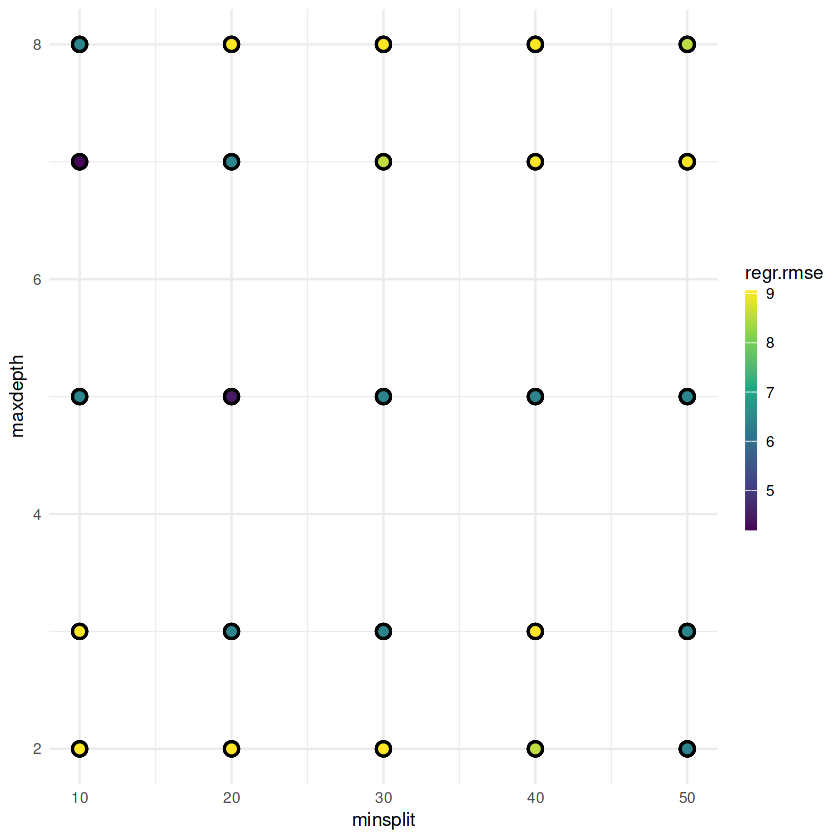

In [39]:

autoplot(at$tuning_instance, type = "points",
cols_x = c("minsplit", "maxdepth"))

(6) 训练模型

自动调参器已经使用超参数调参得到最优超参数在整个训练集上重新训练，取出该模型结果，可以跟直接用 rpart::rpart() 训练模型得到的模型结果一样使用。

In [40]:
model = at$learner$model
#查看特征重要性：
at$learner$importance()

AT         V        AP        RH 
1752499.5 1337944.2  614460.5  448062.8

(7) 模型预测及评估

在测试集上做预测：

In [41]:
pred = at$predict(task, row_ids = split$test)
pred

<PredictionRegr> for 2870 observations:
    row_ids  truth response
          7 467.35 463.7854
         14 451.28 444.3014
         27 464.16 466.9754
---                        
       9540 472.32 473.8700
       9548 484.22 481.9238
       9551 481.03 477.3000

(8) 评估模型性能

回归问题评估 RMSE 和 $𝑅^2$：

In [42]:
pred$score(msrs(c("regr.rmse", "regr.rsq")))

regr.rmse  regr.rsq 
4.0793268 0.9420034

(9) 预测新数据

In [43]:
newdata = task$data()[1:5,-1]
at$predict_newdata(newdata)

<PredictionRegr> for 5 observations:
 row_ids truth response
       1    NA 462.6677
       2    NA 444.3014
       3    NA 485.4877
       4    NA 447.7344
       5    NA 473.8700